Copyright 2019 The Google Research Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Data Valuation using DVRL

 * Jinsung Yoon, Sercan O Arik, Tomas Pfister, "Data Valuation using Reinforcement Learning", arXiv preprint arXiv:1909.11671 (2019) - https://arxiv.org/abs/1909.11671
 
This notebook describes the user-guide of a data valuation application using "Data Valuation using Reinforcement Learning (DVRL)".

With a small validation set, DVRL can provide computationally highly efficient and high quality ranking of data values for the training dataset.

You need:

**Training / Validation / Testing sets** 
 * For data valuation, there is not constraint on the datasets. If you do not have a validation set, you can simply split a small portion of the training set as the validation set (we will use validation set to get performance feedback in DVRL).
 * If you have your own training / validation / testing sets, you should save those files as 'train.csv', 'valid.csv', 'test.csv' under './repo/data_files/' directory.
 * In this notebook, we use adult income dataset (https://archive.ics.uci.edu/ml/datasets/Adult) as an example.

##  Prerequisite

 * Download lightgbm package.
 * Clone https://github.com/google-research/google-research.git to the current directory.

In [3]:
# # Uses pip3 to install necessary package (lightgbm)
# !pip3 install lightgbm

# # Resets the IPython kernel to import the installed package.
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)  

In [1]:
# import os
# from git import Repo

# # Current working directory
# repo_dir = os.getcwd() + '/repo'

# if not os.path.exists(repo_dir):
#     os.makedirs(repo_dir)

# # Clones github repository
# if not os.listdir(repo_dir):
#     git_url = "https://github.com/google-research/google-research.git"
#     Repo.clone_from(git_url, repo_dir)

## Necessary packages and functions call

 * data_loading: Data loader for tabular datasets.
 * data_preprocess: Data extraction and normalization.
 * dvrl_classification: Data valuation function for classification problem.
 * metrics: Evaluation metrics of the quality of data valuation in various metrics.

In [8]:
import numpy as np
import keras
import tensorflow as tf
import pandas as pd
import lightgbm

# Sets current directory
# os.chdir(repo_dir)
import sys


from data_loading import load_tabular_data, preprocess_data
import dvrl
from dvrl_metrics import remove_high_low

/Users/yuto/anaconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'tensorflow.contrib'

## Data loading

 * Create training, validation and testing sets and save them as train.csv, valid.csv, test.csv under './repo/data_files/ directory.
 * If you have your own train.csv, valid.csv, test.csv, just save them '.repo/data_files/' directory and you can skip this cell.

In [4]:
# Data name: 'adult' in this notebook
data_name = 'adult'

# The number of training and validation samples
dict_no = dict()
dict_no['train'] = 1000
dict_no['valid'] = 400

# Loads data
_ = load_tabular_data(data_name, dict_no, 0.0)

print('Finished data loading.')

Finished data loading.


## Data preprocessing

 * Extract features and labels from train.csv, valid.csv, test.csv in './repo/data_files/' directory.
 * Normalize the features of training, validation, and testing sets.

In [5]:
# # Normalization methods: either 'minmax' or 'standard'
# normalization = 'minmax' 

# # Extracts features and labels. Then, normalizes features.
# x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = \
# preprocess_data(normalization, 'train.csv', 'valid.csv', 'test.csv')

# csv fileを直接読み込む
x_train = pd.read_csv("data/x_train.csv").values
y_train = pd.read_csv("data/y_train_noise.csv").loc[:, ["domain1_score"]].values / 12 # データフレーム型として抽出するために[]が多い
noise_train = pd.read_csv("data/y_train_noise.csv").loc[:, "is_noise"]

x_valid = pd.read_csv("data/x_valid.csv").values
y_valid = pd.read_csv("data/y_valid_noise.csv").loc[:, ["domain1_score"]].values / 12
noise_valid = pd.read_csv("data/y_valid_noise.csv").loc[:, "is_noise"]

x_test = pd.read_csv("data/x_test.csv").values
y_test = pd.read_csv("data/y_test_noise.csv").loc[:, ["domain1_score"]].values / 12
noise_test = pd.read_csv("data/y_test_noise.csv").loc[:, "is_noise"]
print(y_train.max(), y_valid.max(), y_test.max())

print('Finished data preprocess.')

1.0 1.0 1.0
Finished data preprocess.


## Run DVRL

1. **Input**: 

 * data valuator network parameters: Set network parameters of data valuator.
 * pred_model: The predictor model that maps output from the input. Any machine learning model (e.g. a neural network or ensemble decision tree) can be used as the predictor model, as long as it has fit, and predict (for regression)/predict_proba (for classification) as its subfunctions. Fit can be implemented using multiple backpropagation iterations.
 
 
2. **Output**:
 * data_valuator: Data value estimator function that can return the estimate data values for each sample.
 * dvrl_predictor: Function that predicts labels of the testing samples.
 * dve_out: Estimated data values of the entire training samples.

In [6]:
# Resets the graph
tf.reset_default_graph()
keras.backend.clear_session()
  
# Defines problem
problem = 'regression'

# Network parameters
parameters = dict()
parameters['hidden_dim'] = 100
parameters['comb_dim'] = 10
parameters['iterations'] = 400
parameters['activation'] = tf.nn.relu
parameters['inner_iterations'] = 100
parameters['layer_number'] = 5
parameters['batch_size'] = 2000
parameters['batch_size_predictor'] = 256
parameters['learning_rate'] = 0.01

# Defines predictive model
pred_model = keras.models.Sequential()
pred_model.add(keras.layers.Dense(parameters['hidden_dim'], activation='relu'))
pred_model.add(keras.layers.Dense(parameters['hidden_dim'], activation='relu'))
pred_model.add(keras.layers.Dense(1))
pred_model.compile(optimizer='adam', loss='mean_squared_error',
                   metrics=['mae'])

# Sets checkpoint file name
checkpoint_file_name = './tmp/model.ckpt'

# Flags for using stochastic gradient descent / pre-trained model
flags = {'sgd': True, 'pretrain': False}

# Initializes DVRL
dvrl_class = dvrl.Dvrl(x_train, y_train, x_valid, y_valid,
                       problem, pred_model, parameters, checkpoint_file_name, flags)

# Trains DVRL
dvrl_class.train_dvrl('mse')

print('Finished dvrl training.')

# Estimates data values
dve_out = dvrl_class.data_valuator(x_train, y_train)

# Predicts with DVRL
y_test_hat = dvrl_class.dvrl_predictor(x_test)

print('Finished data valuation.')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(1070, 1)



2023-11-23 14:40:46.083415: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-11-23 14:40:46.085854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-23 14:40:46.085917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 4090 major: 8 minor: 9 memoryClockRate(GHz): 2.52
pciBusID: 0000:01:00.0
2023-11-23 14:40:46.085969: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-11-23 14:40:46.085996: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10.0'; dlerror:

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




2023-11-23 14:40:49.195561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-11-23 14:40:49.195582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
100%|██████████| 1000/1000 [32:53<00:00,  1.97s/it]


Finished dvrl training.
INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
Finished data valuation.


2023-11-23 15:13:44.956845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-11-23 15:13:44.956877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


## Evaluations

 * In this notebook, we use LightGBM as the predictor model in DVRL (but we can also replace it with another model for evaluation purposes).
 * Here, we use average accuracy as the performance metric but you can replace it with other metrics such as AUC.

### 1. Data valuation
DVRL learns the value of each training sample (individually) with a small validation set via reinforcement learning. Therefore, DVRL can provide the ranking of the training samples based on the estimated values of training samples.

* sorted_idx: Sorted training sample index based on the estimated data values by DVRL (decreasing order).
* sorted_x_train: Sorted training features based on the estimated data values by DVRL (decreasing order).
* sorted_y_train: Sorted training labels based on the estimated data values by DVRL (decreasing order).

In [7]:
# Data valuation
sorted_idx = np.argsort(-dve_out)
sorted_x_train = x_train[sorted_idx]
sorted_y_train = y_train[sorted_idx]

# The number of examples
n_exp = 5

# Indices of top n high valued samples
print('Indices of top ' + str(n_exp) + ' high valued samples: ' + str(sorted_idx[:n_exp]))
# pd.DataFrame(data=sorted_x_train[:n_exp, :], index=range(n_exp), columns=col_names).head()
pd.DataFrame(data=sorted_x_train[:n_exp, :], index=range(n_exp)).head()

Indices of top 5 high valued samples: [610 430 302 902   8]


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.000470,-0.013321,0.033953,0.009163,-0.007808,0.037880,0.069443,0.035050,0.064900,0.027019,...,0.069622,-0.020821,0.075962,0.039598,-0.054971,0.030394,0.115262,0.016596,-0.070809,-0.018027
1,0.065988,0.017051,0.054446,0.026707,0.076306,0.044990,0.109810,0.124166,0.038596,-0.013955,...,-0.039592,0.033106,0.028629,0.069433,-0.007279,-0.009708,0.011299,0.014434,-0.129975,-0.006575
2,-0.001137,0.022212,0.075174,-0.058847,0.022140,0.009041,0.001550,0.033379,0.042197,-0.029181,...,0.055358,-0.111095,0.015808,-0.006142,0.027524,0.097847,-0.002620,-0.029606,-0.064929,-0.027531
3,0.008056,0.044459,0.109724,-0.021097,0.074404,0.055013,0.168793,0.039668,0.042843,0.027528,...,-0.017431,-0.019280,0.036085,0.065322,-0.029916,0.078862,0.053762,0.029062,-0.063421,0.038935
4,-0.033680,0.005977,0.067792,-0.029088,0.129800,0.045921,0.142340,0.023382,0.052852,0.046329,...,0.014641,-0.000032,0.029676,0.064711,-0.022582,0.054510,0.056430,0.120448,-0.036264,-0.008244


In [8]:
# Indices of top n low valued samples
print('Indices of top ' + str(n_exp) + ' low valued samples: ' + str(sorted_idx[-n_exp:]))
# pd.DataFrame(data=sorted_x_train[-n_exp:, :], index=range(n_exp), columns=col_names).head()
pd.DataFrame(data=sorted_x_train[-n_exp:, :], index=range(n_exp)).head()

Indices of top 5 low valued samples: [1064   52  292   96  199]


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.019148,0.032918,0.047289,-0.041911,0.034080,0.044017,0.112709,0.076717,0.065965,0.026608,...,0.045518,-0.035486,0.059415,0.021008,-0.039824,0.108040,0.043439,0.020510,-0.053619,0.026851
1,0.017536,0.037830,0.052547,-0.080948,0.014723,-0.008120,0.146829,0.059831,0.017741,0.009337,...,0.043836,-0.014102,0.049689,0.034176,-0.041410,0.048736,0.018805,0.100027,-0.129318,-0.030971
2,-0.075100,0.054039,0.066746,0.017584,0.063144,0.032268,0.092288,0.065018,0.024584,0.026511,...,0.002092,0.003491,0.010867,0.058797,0.009328,0.073034,0.107896,0.000983,-0.031588,0.010996
3,0.004359,-0.058940,0.062555,-0.057283,0.074591,-0.014806,0.099021,0.029683,0.060262,0.024729,...,0.064334,0.027335,0.022887,0.005276,-0.052704,0.050058,0.055573,0.042522,-0.084594,0.017644
4,0.028890,0.003684,0.122584,0.022654,0.129360,-0.028545,0.098086,0.012882,-0.023676,0.003309,...,0.016940,0.009494,0.026815,0.060726,-0.039769,0.124994,0.061900,-0.007982,-0.134930,-0.011542


### 2. Removing high/low valued samples

Removing low value samples from the training dataset can improve the predictor model performance, especially in the cases where the training dataset contains corrupted samples. On the other
hand, removing high value samples, especially if the dataset is small, would decrease the performance significantly. Overall, the performance after removing high/low value samples is a strong
indicator for the quality of data valuation.

DVRL can rank the training data samples according to their estimated data value, and **by removing the low value samples we can improve performance, whereas removing the high value samples degrades the performance**.
 * Train predictive models after removing certain portions of high/low valued training samples.
 * Visualize the results using line graphs (set plot = True).
 * x-axis: Portions of removed samples.
 * y-axis: Prediction performance (accuracy).
 * Blue line: Removing low value data, Orange line: Removing high value data.

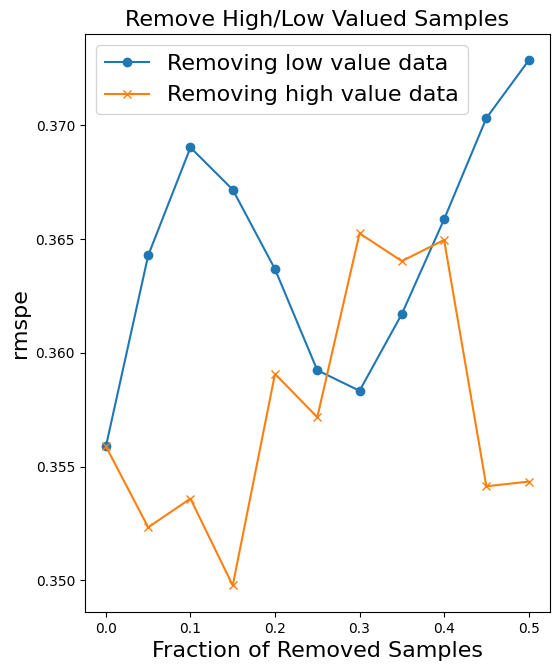

In [9]:
# Defines evaluation model
# lightGBMが良くないかも　ニューラルに変えたい
eval_model = lightgbm.LGBMRegressor()

# Evaluates performances after removing high/low valued samples
remove_high_low_performance = remove_high_low(dve_out, eval_model, x_train, y_train, 
                                              x_valid, y_valid, x_test, y_test, 'rmse', plot = True)

In [28]:
# The number of examples
n_exp = 20

# Indices of top n low valued samples
print('Indices of top ' + str(n_exp) + ' low valued samples: ' + str(sorted_idx[-n_exp:]))
# pd.DataFrame(data=sorted_x_train[-n_exp:, :], index=range(n_exp), columns=col_names).head()
pd.DataFrame(data=sorted_x_train[-n_exp:, :], index=range(n_exp)).head()

print(noise_train[sorted_idx[-n_exp:]])

Indices of top 20 low valued samples: [ 547  797  125  622  567  562  681  339  674  225  718   36  589  750
  766 1064   52  292   96  199]
547      True
797     False
125      True
622      True
567      True
562      True
681     False
339      True
674      True
225      True
718      True
36       True
589      True
750      True
766      True
1064     True
52       True
292      True
96       True
199      True
Name: is_noise, dtype: bool


In [29]:
# The number of examples
n_exp = 20

# Indices of top n high valued samples
print('Indices of top ' + str(n_exp) + ' high valued samples: ' + str(sorted_idx[:n_exp]))
# pd.DataFrame(data=sorted_x_train[:n_exp, :], index=range(n_exp), columns=col_names).head()
pd.DataFrame(data=sorted_x_train[:n_exp, :], index=range(n_exp)).head()

print(noise_train[sorted_idx[:n_exp]])

Indices of top 20 high valued samples: [ 610  430  302  902    8   67  974  972   41  933  325 1041   89  815
  699  664 1055 1023  435  655]
610     False
430     False
302     False
902     False
8       False
67      False
974     False
972     False
41      False
933     False
325     False
1041    False
89      False
815     False
699     False
664     False
1055    False
1023    False
435     False
655     False
Name: is_noise, dtype: bool


In [32]:
print(dve_out[sorted_idx[-n_exp:]])

[1.9310415e-03 1.8734932e-03 1.5898645e-03 1.4650822e-03 1.3403296e-03
 1.2499392e-03 7.5677037e-04 5.3444505e-04 4.7856569e-04 3.9932132e-04
 3.5017729e-04 2.5883317e-04 1.1828542e-04 9.3698502e-05 2.2798777e-05
 9.3841063e-06 3.5166740e-06 3.3974648e-06 1.6987324e-06 7.1525574e-07]
